### Cab-Driver Agent

In [8]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import numpy as np
# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

#### Defining Time Matrix

In [9]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

#### Tracking the state-action pairs for checking convergence


In [10]:
States_track = collections.defaultdict(dict)

In [11]:
# Initialise states to be tracked
def initialise_tracking_states():
    sample_q_values = [
                   ((0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0),(1,3)),
                   ((0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0),(4,1)),
                   ((0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0),(2,3)),
                   ((1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1),(1,4))]    
    for q_values in sample_q_values:
        state = q_values[0] 
        action = q_values[1]      
        States_track[state][action] = []  

In [12]:
initialise_tracking_states()

In [13]:
def save_tracking_states(state,action,rewards):
    if state in States_track.keys():
        if action in States_track[state].keys():
            States_track[state][action].append(rewards)

In [14]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [15]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size
        
        # Tracking the loss
        self.track_loss=[]

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.001 
        self.epsilon_max = 1.0
        self.epsilon_decay = 0.0003
        self.epsilon_min = 0.00000001

        self.batch_size = 32 

        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()
        self.target_model = self.build_model()
        
        # initialize target model
        self.update_target_model()
        
    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets       
        # hidden layers
        model.add(Dense(256, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(150, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
        # the output layer: output is of size num_actions
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model

    # after some time interval update the target model to be same with model
    def update_target_model(self):
        '''
        TODO:
        Update the target Q-value network to current Q-value network after training for a episode. This means that weights an
        biases of target Q-value network will become same as current Q-value network.
        '''
        self.target_model.set_weights(self.model.get_weights())


    def get_action(self, state,request_actions):
    # Write your code here:
    # get action from model using epsilon-greedy policy
    # Decay in ε after we generate each sample from the environment       
        if np.random.rand() <= self.epsilon_max:
            # explore: choose a random action from all possible actions
            # in case of cartpole this will randomly choose an action between 0 and 1
            return request_actions[random.randrange(len(request_actions))]
        else:
            # choose the action with the highest q(s, a)
            # the first index corresponds to the batch size, so
            # reshape state to (1, state_size) so that the first index corresponds to the batch size
            state = state.reshape(1, self.state_size)
            q_value = self.model.predict(state)
            return np.argmax(q_value[0])    

    def append_sample(self, state, action, reward, next_state,done):
    # Write your code here:
    # save sample <s,a,r,s',done> to the replay memory
        self.memory.append((state, action, reward, next_state,done))
    
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_target = np.zeros((self.batch_size, self.state_size))# write here
            update_input = np.zeros((self.batch_size, self.state_size))# write here
            
            actions, rewards, done = [], [],[]
            
            for i in range(self.batch_size):
                state, action, reward, next_state,done_boolean = mini_batch[i]
                update_input[i] = state
                actions.append(action)
                rewards.append(reward)
                update_target[i] = next_state
                done.append(done_boolean)
                
            # Write your code from here
            # 1. Predict the target from earlier model
            target = self.model.predict(update_input)
            
            # 2. Get the target for the Q-network
            target_qval = self.target_model.predict(update_target)
            
            #3. Update your 'update_output' and 'update_input' batch
            for i in range(self.batch_size):
                if done[i]:
                    target[i][actions[i]] = rewards[i]
                else: # non-terminal state
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])

            # 4. Fit your model and track the loss values
            history=self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
            self.track_loss.append(history.history['loss'])


    def get_model_weights(self):
        return self.model.get_weights()


In [16]:
Episodes=1000
env=CabDriver()
action_size=env.action_size
state_size=env.state_size
#Call the DQN agent
agent=DQNAgent(state_size=state_size,action_size=action_size)
rewards_per_episode, episodes = [], []

### DQN block

In [17]:
for episode in range(Episodes):

    # Write code here
    # Call the environment
    # Call all the initialised variables of the environment
   
    terminal_state=False
    score=0  
    env_initalized=env.reset()
    state=env_initalized[2]
    # episode_lenght=-1
    while not terminal_state:
        # episode_lenght+=1
        # Write your code here
        # 1. Pick epsilon-greedy action from possible actions for the current state
        request_actions=env.requests(state)[1]
        next_action=agent.get_action(env.state_encod_arch1(state),request_actions)  
        # 2. Evaluate your reward and next state
        next_state,action,reward,is_done=env.next_state_func(state,next_action,Time_matrix)
        key_state = tuple(env.state_encod_arch1(state))
        save_tracking_states(key_state,action,reward)
        if action[0]!=0:
            # 3. Append the experience to the memory
            agent.append_sample(env.state_encod_arch1(state),env.action_space.index(action),reward,env.state_encod_arch1(next_state),is_done)
            # 4. Train the model by calling function agent.train_model
            agent.train_model()
            # 5. Keep a track of rewards, Q-values, loss
            score+=reward
        # swapping state with next_state
        state=next_state
        terminal_state=is_done
        
        if terminal_state:
            # every episode update the target model to be same with model
            agent.update_target_model()

    rewards_per_episode.append(score)
    episodes.append(episode)
    # print(episode_lenght)

    
    if agent.epsilon_max > agent.epsilon_min:
        agent.epsilon_max=agent.epsilon_min+(agent.epsilon_max-agent.epsilon_min)*np.exp(-0.000001*episode)
    
    
    if (episode+1) % 100 == 0:                
        save_obj(agent.get_model_weights(), 'weights_per_100_epiosde')
        print("episode {0}, reward {1}, memory_length {2}, epsilon {3}".format(episode,
                                                                         score,
                                                                         len(agent.memory),
                                                                         agent.epsilon_max))
    
        

episode 99, reward -38.0, memory_length 2000, epsilon 0.9950622311098061
episode 199, reward -97.0, memory_length 2000, epsilon 0.9802966982722767
episode 299, reward -225.0, memory_length 2000, epsilon 0.956140892649477
episode 399, reward 8.0, memory_length 2000, epsilon 0.9233009888864626
episode 499, reward -224.0, memory_length 2000, epsilon 0.8827175555633945
episode 599, reward 92.0, memory_length 2000, epsilon 0.8355208317104077
episode 699, reward 71.0, memory_length 2000, epsilon 0.7829785349467155
episode 799, reward 776.0, memory_length 2000, epsilon 0.7264395575237954
episode 899, reward 597.0, memory_length 2000, epsilon 0.6672770212921247
episode 999, reward 736.0, memory_length 2000, epsilon 0.606834004803121


In [18]:
save_obj(rewards_per_episode,"rewards_"+str(Episodes))

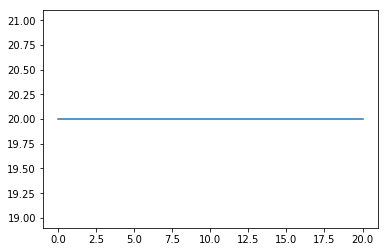

In [19]:
a = (0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0)
plt.plot(States_track[a][(2,3)])
plt.show()

In [20]:
for i in States_track.keys():
    for j in States_track[i].keys():
        print(len(States_track[i][j]))

44
11
21
0


### Tracking Convergence

In [21]:
#=============TODO:

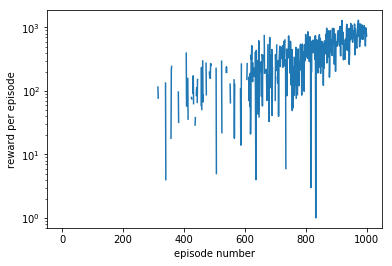

In [22]:
with open('rewards_'+str(Episodes)+'.pkl', 'rb') as f:
    rewards_per_episode = pickle.load(f)

plt.plot(list(range(len(rewards_per_episode))), rewards_per_episode)
plt.xlabel("episode number")
plt.ylabel("reward per episode")
plt.yscale('log')
plt.show()

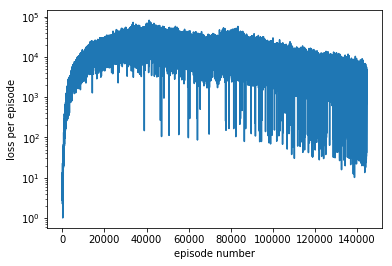

In [23]:
# Tracking loss

plt.plot(list(range(len(agent.track_loss))), agent.track_loss)
plt.xlabel("episode number")
plt.ylabel("loss per episode")
plt.yscale('log')
plt.show()

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [26]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

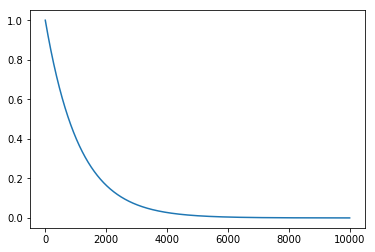

In [27]:
plt.plot(time, epsilon)
plt.show()

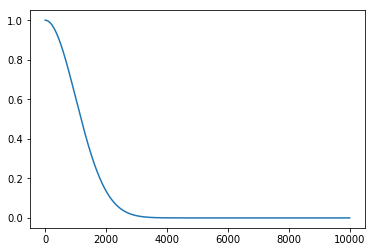

In [28]:
time = np.arange(0,10000)
epsilon_max = 1.0
epsilon_decay = 0.0003
epsilon_min = 0.00000001
epsilon = []
for i in range(0,10000):
    epsilon_max=epsilon_min+(epsilon_max-epsilon_min)*np.exp(-0.000001*i)
    epsilon.append(epsilon_max)  
plt.plot(time, epsilon)
plt.show() 